In [1]:
import networkx as nx
import matplotlib as mpl
from searchspace import *

In [3]:
distances, idxs = define_space_search_graph(['E2', 'S2', 'H2'], 10, connectivity=False)
graph = nx.from_numpy_array(distances)
colors = [get_color(graph.get_edge_data(*edge)['weight']) for edge in graph.edges()]

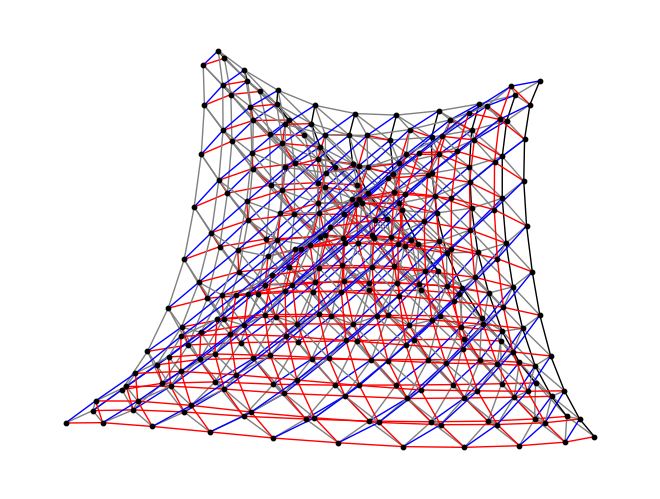

In [4]:
nx.draw(graph, node_size=10, node_color='black', edge_color=colors)

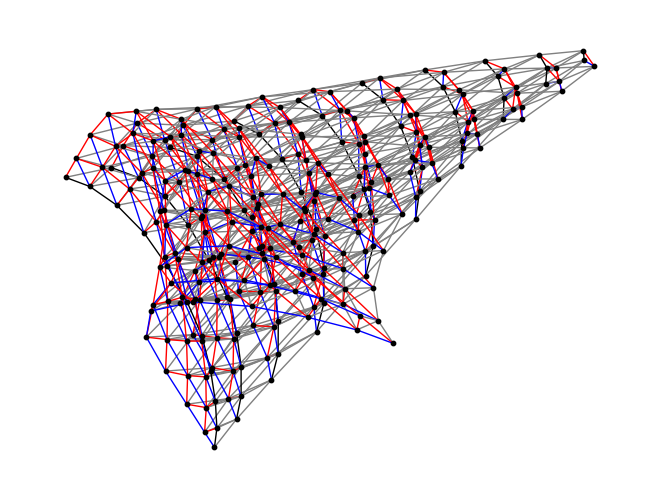

In [5]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=10, node_color='black', edge_color=colors)